In [1]:
import datetime
import pandas as pd
import numpy as np
from collections import defaultdict
from typing import Dict, List, Optional, Tuple, Union

from pylab import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from bigbang.analysis.listserv import ListservMailList
#from bigbang.bigbang_io import pandas_dataframe_to_mbox

from tgpp.config.config import CONFIG
import tgpp.ingress.queries as Queries

plt.style.use("./publication_jcap.mplstyle")

In [2]:
def format_dictionary(dic: dict, threshold: Union[int, float]) -> dict:
    """
    Format dictionary for pie plot.
    """
    dic_sorted = {
        list(dic.keys())[indx]: list(dic.values())[indx]
        for indx in np.argsort(list(dic.values()))[::-1]
    }

    percentages = ListservMailList.to_percentage(list(dic_sorted.values()))
    dic_sorted = {key: value for key, value in zip(dic_sorted.keys(), percentages)}

    dic_filtered = {"others": 0}
    
    if isinstance(threshold, int):
        for index, (key, value) in enumerate(dic_sorted.items()):
            if index <= threshold:
                dic_filtered[key] = value
            else:
                dic_filtered["others"] += value
    elif isinstance(threshold, float):
        for key, value in dic_sorted.items():
            if value >= threshold:
                dic_filtered[key] = value
            else:
                dic_filtered["others"] += value
    return dic_filtered

## Load data

In [3]:
# Load data on organisations in 3GPP

file_path = "/Users/christovis/Documents/InternetGovernance/bigbang/examples/organizations/organization_categories.csv"
df_organization_categories = pd.read_csv(
    file_path,
    sep=",",
    header=0,
    index_col=False,
)
# choose columns of interest
df_nation = df_organization_categories[[
    "name",
    "nationality",
    "email domain names",
]]
# filter out all non-empty cells
df_nation = df_nation.dropna()

indices = [
    idx
    for idx, row in df_nation.iterrows()
    if len(row['email domain names'].split(',')) > 1
]    

df_nation_multi = df_nation.loc[indices]
df_nation_single = df_nation.drop(indices)

_df_nation_multi = defaultdict(list)
for idx, row in df_nation_multi.iterrows():
    _row = row
    email_domains = row['email domain names'].split(',')
    for email_domain in email_domains:
        _row['email domain names'] = email_domain.strip()
        for key, value in _row.to_dict().items():
            _df_nation_multi[key].append(value)
df_nation = pd.concat([df_nation_single, pd.DataFrame.from_dict(_df_nation_multi)], ignore_index=True)

In [4]:
# Load Target-set (Tset)
mlist_name = "3GPP_TSG_SA_WG3_LI"

df = pd.read_hdf(
    CONFIG.folder_target_set + f"{mlist_name}.h5",
    key="df",
    header=0,
    index_col=0,
)
df = df.dropna()
df['msg-date'] =  pd.to_datetime(df['msg-date'], format="%a, %d %b %Y %H:%M:%S %z")

In [5]:
# Add nationality to sender in target-set

df['msg-nationality'] = np.nan
for idx, row in df.iterrows():
    _, _, domain = ListservMailList.get_name_localpart_domain(row['msg-from'])
    nationality = df_nation[df_nation['email domain names'] == domain]['nationality'].values
    if len(nationality) > 0:
        # TODO: there are some domain names associated to multiple nationailies
        df.loc[idx, 'msg-nationality'] = nationality[0]
df = df.dropna()
df = Queries.remove_text_wo_query(df)
df = Queries.remove_query_wo_text(df)

In [6]:
# get Tset Email header fields
non_query_columns = [col for col in df.columns if col.startswith('msg-')]
df_msg = df.loc[:, df.columns.isin(non_query_columns)]

# get Tset Email keyterms
df_qu = df.loc[:, ~df.columns.isin(non_query_columns)]
body_query_columns = [col for col in df_qu.columns if col.startswith('body-')]
attachment_query_columns = [col for col in df_qu.columns if col.startswith('attachment-')]
df_qu_bo = df.loc[:, body_query_columns]
df_qu_at = df.loc[:, attachment_query_columns]

df_qu_bo = Queries.remove_text_wo_query(df_qu_bo)
df_qu_bo = Queries.remove_query_wo_text(df_qu_bo)

df_qu_at = Queries.remove_text_wo_query(df_qu_at)
df_qu_at = Queries.remove_query_wo_text(df_qu_at)

# load search-set (Sset)
mlist = ListservMailList.from_mbox(
    name=mlist_name,
    filepath=CONFIG.folder_search_set + f"{mlist_name}.mbox",
)

## Nationality of Tset Email

In [7]:
# Combined appearance in Email body and attachement

key, count = np.unique(df_msg['msg-nationality'].values, return_counts=True)
idx = np.argsort(count)
key = key[idx]
count = count[idx]

for k, c in zip(key, count):
    print(k, c)

Denmark 1
Japan 3
Norway 6
China 9
Netherlands 20
Spain 21
the Netherlands 71
Australia 77
Canada 137
Germany 160
Sweden 167
France 268
United Kingdom 537
United States 553
Finland 669


In [8]:
# Appearance in Email body
# When looking at the Email body and attachment seperatley, the Email body gives a better insight
# into whether the sender has used a specific concept conciously, as the attachments are often
# meeting notes and agendas that don't represent what the sender was concerned about.

notattachment_query_columns = [col for col in df.columns if not col.startswith('attachment-')]
_df = Queries.remove_text_wo_query(df[notattachment_query_columns])
_df = Queries.remove_query_wo_text(_df)
key, count = np.unique(_df['msg-nationality'].values, return_counts=True)
idx = np.argsort(count)
key = key[idx]
count = count[idx]

for k, c in zip(key, count):
    print(k, c)

Denmark 1
Japan 3
Norway 6
China 9
Netherlands 20
Spain 21
the Netherlands 70
Australia 75
Canada 133
Germany 152
Sweden 166
France 248
United Kingdom 471
United States 535
Finland 634


## Count Emails and Attachements containing keyterms

In [9]:
df_qu_bo[df_qu_bo != 0] = 1
queries_count_body = df_qu_bo.sum(axis=0).sort_values()

df_qu_at[df_qu_at != 0] = 1
queries_count_attachment = df_qu_at.sum(axis=0).sort_values()

In [10]:
queries_count_body#[-50::]

body- law intercept identifi        1
body- ld                            1
body- nds                           1
body- gprs li correl                1
body- lipa                          1
                                 ... 
body- lemf                        563
body- lea                         609
body- poi                         760
body- cc                          996
body- iri                        1080
Length: 77, dtype: int64

In [11]:
queries_count_attachment

attachment- intellig network                1
attachment- ilhi                            1
attachment- intercept network element       1
attachment- dpi                             1
attachment- communic ident number           1
                                         ... 
attachment- handov interfac                92
attachment- csp                           100
attachment- lal                           117
attachment- cc                            157
attachment- iri                           160
Length: 89, dtype: int64

## Find Email first to mention keyterms

In [12]:
def find_first_keyterm_mention(df: pd.DataFrame, keyterm: str):
    """
    Parameters:
    -----------
    keyterm: is the same as the column name in the DataFrame.
    
    Returns
    -------
    Returns index of Email tha first mentiones keyterm.
    """
    _df = df[df[keyterm] != 0]
    min_datetime = _df['msg-date'].values.min()
    index = df[df['msg-date'] == min_datetime].index[0]
    return index

body_query_columns = [col for col in df_qu.columns if col.startswith('body-')]
indices = [
    find_first_keyterm_mention(df, column)
    for column in body_query_columns
]
df_bo_first = df.loc[indices]

attachment_query_columns = [col for col in df_qu.columns if col.startswith('attachment-')]
indices = [
    find_first_keyterm_mention(df, column)
    for column in attachment_query_columns
]
df_at_first = df.loc[indices]

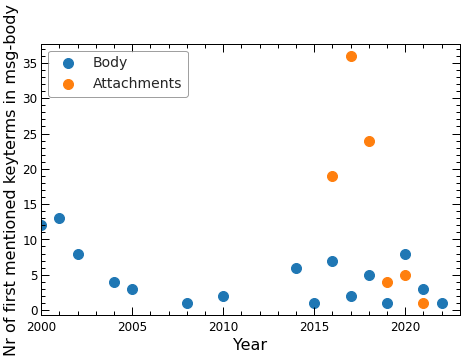

In [13]:
years, couts = np.unique([dt.year for dt in df_bo_first['msg-date']], return_counts=True)
plt.scatter(years, couts, label="Body")

years, couts = np.unique([dt.year for dt in df_at_first['msg-date']], return_counts=True)
plt.scatter(years, couts, label="Attachments")

plt.xlim(2000, 2023)
plt.xlabel('Year')
plt.ylabel('Nr of first mentioned keyterms in msg-body')
plt.legend()

#"""
plt.savefig(
    f"{mlist_name}_time_kw_first_mentioned.png",
    format='png',
    transparent=True,
    dpi=300,
    bbox_inches='tight',
)#"""

## Domains and Nationality of first mentioned keyterms

In [14]:
mlist_bo_first = ListservMailList.from_pandas_dataframe(
    df=mlist.df[mlist.df['message-id'].isin(df_bo_first['msg-message-id'].values)],
    name=mlist_name,
)
mlist_at_first = ListservMailList.from_pandas_dataframe(
    df=mlist.df[mlist.df['message-id'].isin(df_at_first['msg-message-id'].values)],
    name=mlist_name,
)

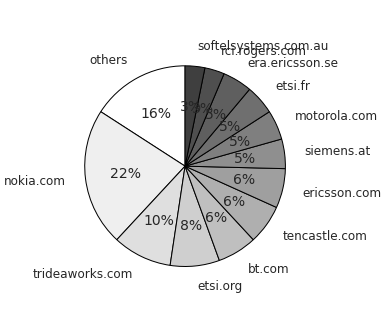

In [15]:
dicts = mlist_bo_first.get_messagescount(
    header_fields=['from', 'comments-to'],
    per_address_field='domain',
    per_year=False,
)
threshold = 11
dict_filtered = format_dictionary(dicts["from"], threshold)

# plot figure
fig, axis = plt.subplots(
    1, 1,
    figsize=(4, 6),
)
nr_colors = len(dict_filtered.values()) + 3
cmap = cm.binary(np.arange(nr_colors) / nr_colors)

axis.pie(
    dict_filtered.values(),
    radius=3.,
    wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': '-'},
    labels=dict_filtered.keys(),
    labeldistance=1.2,
    autopct='%1.f%%',
    shadow=False,
    startangle=90,
    colors=cmap,
)
axis.axis('equal')

#"""
plt.savefig(
    f"{mlist_name}_stakeholder_kw_first_mentioned.png",
    format='png',
    transparent=True,
    dpi=300,
    bbox_inches='tight',
)#"""

In [16]:
dict_filtered = defaultdict(int)
for key, value in dicts["from"].items():
    if key in df_nation["email domain names"].values:
        nationality = df_nation[df_nation["email domain names"] == key]['nationality'].values[0]
        dict_filtered[nationality] += value
        if nationality == 'United States':
            print(nationality, key)

United States verisign.com
United States cisco.com
United States t-mobile.de
United States email.mot.com
United States trideaworks.com
United States motorola.com


In [17]:
timezones = [
    tz[-5:]
    for tz in mlist.crop_by_address(header_field="from", per_address_field={'domain': ['nokia.com']}).df['date'].values
]
np.unique(timezones, return_counts=True)

(array(['+0000', '+0100', '+0200', '+0300'], dtype='<U5'),
 array([767,   1, 129, 157]))

United States verisign.com
United States cisco.com
United States t-mobile.de
United States email.mot.com
United States trideaworks.com
United States motorola.com


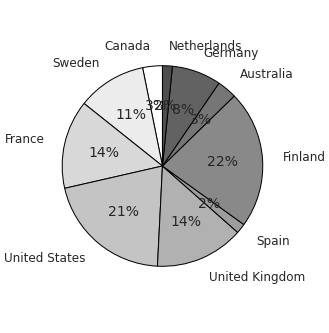

In [18]:
dict_filtered = defaultdict(int)
for key, value in dicts["from"].items():
    if key in df_nation["email domain names"].values:
        nationality = df_nation[df_nation["email domain names"] == key]['nationality'].values[0]
        dict_filtered[nationality] += value
        if nationality == 'United States':
            print(nationality, key)

# plot figure
fig, axis = plt.subplots(
    1, 1,
    figsize=(4, 6),
)
nr_colors = len(dict_filtered.values()) + 3
cmap = cm.binary(np.arange(nr_colors) / nr_colors)

axis.pie(
    dict_filtered.values(),
    radius=3.,
    wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': '-'},
    labels=dict_filtered.keys(),
    labeldistance=1.2,
    autopct='%1.f%%',
    shadow=False,
    startangle=90,
    colors=cmap,
)
axis.axis('equal')

#"""
plt.savefig(
    f"{mlist_name}_nationality_kw_first_mentioned.png",
    format='png',
    transparent=True,
    dpi=300,
    bbox_inches='tight',
)#"""

## Domains mentioning keyterms

In [19]:
nonattachment_query_columns = [col for col in df_qu.columns if not col.startswith('attachment-')]
df_bo = df.loc[:, nonattachment_query_columns]
df_bo = Queries.remove_text_wo_query(df_bo)
df_bo = Queries.remove_query_wo_text(df_bo)
mlist_bo = ListservMailList.from_pandas_dataframe(
    df=mlist.df[mlist.df['message-id'].isin(df_bo['msg-message-id'].values)],
    name=mlist_name,
)

KeyError: 'msg-message-id'

In [ ]:
cooccurrence = _df_kw.T.dot(_df_kw).values
np.fill_diagonal(cooccurrence, 0)
#cooccurrence = cooccurrence / np.max(cooccurrence)
df_cooccurrence = pd.DataFrame(
    cooccurrence,
    index=keywords,
    columns=keywords,
)
# re-scale
df_cooccurrence = df_cooccurrence.apply(lambda x: x**(1/2))
# mask upper-right triangle
df_cooccurrence = df_cooccurrence.where(
    np.tril(np.ones(df_cooccurrence.shape)).astype(np.bool)
)

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    sharex=False, sharey=False,
    figsize=(16, 16),
    facecolor="w",
    edgecolor="k",
)
fig.subplots_adjust(
    hspace=0.0,
    wspace=0.0,
)

hmap = sns.heatmap(
    df_cooccurrence,
    cmap="Spectral",
    square=True,
    linewidths=0.5,
    cbar_kws={
        'label': r'$\sqrt{\epsilon}$, with $\epsilon =$ co-occurrence count',
        'shrink': 0.8,
    },
)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0)